# Analyzing NYC High School Data

## Scenario

For a brief bit of background, the SAT, or Scholastic Aptitude Test, is a test that high school seniors in the U.S. take every year. The SAT has three sections, each is worth 800 points. Colleges use the SAT to determine which students to admit. High average SAT scores are usually indicative of a good school.

New York City has published data on student SAT scores by high school, along with additional demographic datasets. The city also has a significant immigrant population and is very diverse, so comparing demographic factors such as race, income, and gender with SAT scores is a good way to determine whether the SAT is a fair test. For example, if certain racial groups consistently perform better on the SAT, we would have some evidence that the SAT is unfair.

## Goal

Explore relationships between demographics and SAT scores.

## Results

Exclusive to this New York study, we found geographical, racial, gender, and institutional differences that impact a student's SAT score.

The average student enrolled in a New York high school scores a 1223 on the SAT. 

**Geographical**:
- Staten Island schools have the highest average out of all the boroughs with an SAT score of 1383. They also have the highest percentage of survey respondents. This would indicate that many of these schools have higher SAT preparation and academic standards. 
- The Bronx has the lowest SAT average with a score of 1158.

**Racial**:
- Schools with higher populations of whites or asians tend to have higher SAT scores.
- Schools with higher populations of blacks or hispanics are negatively correlated with SAT score. Notably, the students from these schools report lower safety and respect scores indicating their learning environment lacks elements for proper academic growth.
- There is also a significant number of hispanic-only schools that are specialized towards immigrants who are new to the country.

**Gender**:
- Many of the schools with a high male population and high SAT score have a high asian population with the exception of Staten Island schools which are predominantly white male. Only one school in this category has a more equal racial distribution.
- The four schools with a high female population and high SAT score are located in Manhattan and Queens. The three located in Manhattan are predominantly white female while the one in Queens is predominantly asian female.
- The all-girls leadership schools have high black and hispanic populations and are located mainly in Manhattan.

**Institutional**: 
- Schools with a higher percentage of AP exam taking students or survey respondents tend to score higher on the SAT.

# Table of Contents

- Part 1: Data preprocessing
- Part 2: Data cleanup
- Part 3: Survey response correlation with SAT score
- Part 4: Geographic correlations with SAT score
- Part 5: Geographic correlations with SAT score (by borough)
- Part 6: Race correlations with SAT score
- Part 7: Gender correlations with SAT score
- Part 8: AP exam scores vs. SAT score

# Part 1: Data preprocessing

## Import the libraries

In [1]:
import numpy as np
import pandas as pd
import re
import logging
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from IPython import display

%matplotlib inline
warnings.filterwarnings("ignore")
logging.basicConfig(level=logging.CRITICAL)

## Importing the data files

In [2]:
files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv",
]

data = {}

for file in files:
    contents = pd.read_csv(f"schools/{file}")
    file = file.replace(".csv", "")
    data[file] = contents

## Import the survey files

In [3]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)


survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]

survey = survey.loc[:, survey_fields]
data["survey"] = survey

The survey data comes with a [data dictionary](https://data.cityofnewyork.us/Education/2011-NYC-School-Survey/mnz3-dyi8) that describes each of the field names.

# Part 2: Data cleanup

## Add DBN columns

In [4]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

## Convert columns to numeric

In [5]:
cols = ["SAT Math Avg. Score", "SAT Critical Reading Avg. Score", "SAT Writing Avg. Score"]
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data["sat_results"]["sat_score"] = data["sat_results"][cols[0]] + data["sat_results"][cols[1]] + data["sat_results"][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

## Condense datasets

In [6]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").mean(numeric_only=True)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

## Convert AP scores to numeric

In [7]:
cols = ["AP Test Takers ", "Total Exams Taken", "Number of Exams with scores 3 4 or 5"]

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

## Combine the datasets

In [8]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean(numeric_only=True))
combined = combined.fillna(0)

## Add a school district column for mapping

In [9]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Part 3: Survey response correlation with SAT score

## Define function to remove edges of visual charts

In [10]:
def remove_spines():
    for ax in axes:
        for spine in spines:
            ax.spines[spine].set_visible(False)
            ax.tick_params(left=0, bottom=0)
            ax.grid(alpha=0.5)

## Find correlations to SAT score

In [11]:
sat_score_corr = combined.corr(numeric_only=True)["sat_score"]
print(sat_score_corr)

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
priority08                              NaN
priority09                              NaN
priority10                              NaN
lat                               -0.121029
lon                               -0.132222
Name: sat_score, Length: 67, dtype: float64


SAT score is highly correlated with each section score. This is expected as the section scores add up to the total SAT score.

## Plot survey correlations

In [12]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

In [13]:
print(survey_fields)

['rr_s', 'rr_t', 'rr_p', 'N_s', 'N_t', 'N_p', 'saf_p_11', 'com_p_11', 'eng_p_11', 'aca_p_11', 'saf_t_11', 'com_t_11', 'eng_t_11', 'aca_t_11', 'saf_s_11', 'com_s_11', 'eng_s_11', 'aca_s_11', 'saf_tot_11', 'com_tot_11', 'eng_tot_11', 'aca_tot_11']


<Axes: >

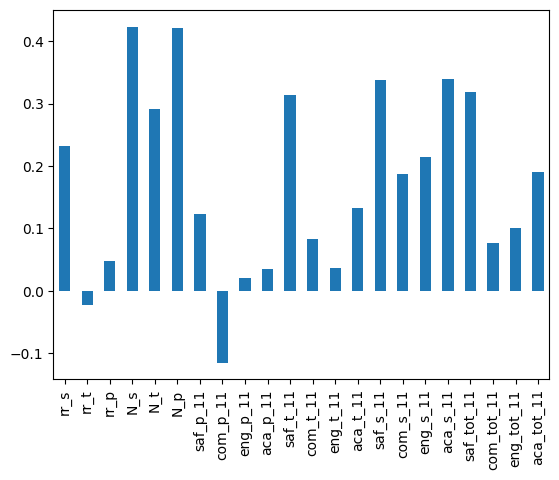

In [14]:
sat_score_corr[survey_fields].plot.bar()

The survey fields that are highly correlated with SAT score are:
- `N_s`: number of student respondents
- `N_p`: number of parent respondents
- `N_t`: number of teacher respondents
- `saf_t_11`: Safety and Respect score based on teacher responses
- `saf_s_11`: Safety and Respect score based on student responses
- `aca_s_11`:  Academic expectations score based on student responses


**Number of respondents**

There is a high correlation with the number of students `N_s`, parents `N_p`, and teachers `N_t` that completed the survey to the SAT score of the student. 

This may indicate that these students come from schools who proactively prepare their students. Another possibility is that the students who are doing well with their academics are more likely to complete the survey.

**Safety and Respect scores**

Also highly correlated with SAT score are scores that students `saf_s_11` and teachers `saf_t_11` provided regarding safety and respect in their learning environment. This seems reasonable as supportive and safe environments can be more conducive to higher academic performance. Interestingly enough, the parent score `saf_p_11` is slightly negatively correlated. As parents do not participate in the learning environment to the extent that students and teachers do, they may have a very skewed perspective on it.

Note the aggregate `saf_tot_11` score which we will disregard as we want to explore the student and teacher scores more granularly.

**Academic expectations**

How the student perceives academic standards is highly correlated with SAT score. It is reasonable that they are more keenly aware of how their academics have prepared them and how to align with academic expectations. On the other hand, the perception of academic standards by teachers and parents are not great indicators for how high the student scored on the SAT.

With all these points in mind, we explore both:
1. the number of respondents, and
2. Safety and Respect scores

# Part 4: Geographic correlations with SAT score

## Average SAT score of New York high school student

In [15]:
print(round(combined["sat_score"].mean(numeric_only=True)))

1223


## Number of respondents vs. SAT score

[Text(0, 800.0, ''),
 Text(0, 1000.0, ''),
 Text(0, 1200.0, ''),
 Text(0, 1400.0, ''),
 Text(0, 1600.0, ''),
 Text(0, 1800.0, ''),
 Text(0, 2000.0, ''),
 Text(0, 2200.0, '')]

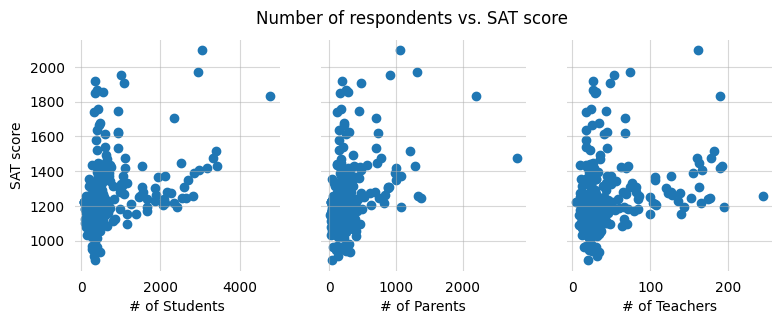

In [16]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(9,3))
fig.suptitle("Number of respondents vs. SAT score")
ax1.scatter(combined["N_s"], combined["sat_score"])
ax2.scatter(combined["N_p"], combined["sat_score"])
ax3.scatter(combined["N_t"], combined["sat_score"])

axes = [ax1, ax2, ax3]
spines = ["left", "right", "top", "bottom"]

remove_spines()

ax1.set_xlabel("# of Students")
ax2.set_xlabel("# of Parents")
ax3.set_xlabel("# of Teachers")
ax1.set_ylabel("SAT score")

ax2.set_yticklabels([])
ax3.set_yticklabels([])

There appears to be a weak positive correlation with how many students, parents, and teachers completed the survey to how high the student scored on the SAT. 

## Safety and Respect score based on respondent response vs. SAT score

[Text(0, 800.0, ''),
 Text(0, 1000.0, ''),
 Text(0, 1200.0, ''),
 Text(0, 1400.0, ''),
 Text(0, 1600.0, ''),
 Text(0, 1800.0, ''),
 Text(0, 2000.0, ''),
 Text(0, 2200.0, '')]

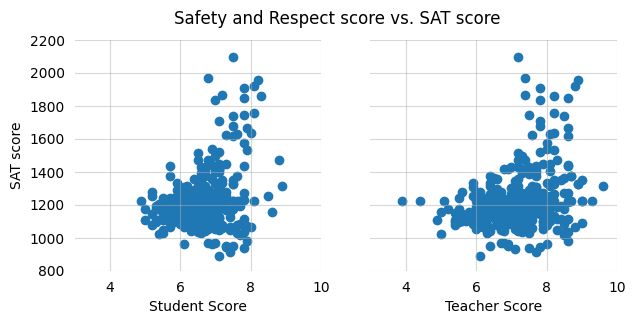

In [17]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(7,3))
fig.suptitle("Safety and Respect score vs. SAT score")
ax1.scatter(x=combined["saf_s_11"], y=combined["sat_score"])
ax2.scatter(x=combined["saf_t_11"], y=combined["sat_score"])

axes = [ax1, ax2]
spines = ["left", "right", "top", "bottom"]

remove_spines()

for ax in axes:
    for spine in spines:
        ax.set_xlim(3, 10)
        ax.set_ylim(800, 2200)
        
ax1.set_xlabel("Student Score")
ax2.set_xlabel("Teacher Score")
ax1.set_ylabel("SAT score")
        
ax2.set_yticklabels([])

For schools rated 7 out of 10 or lower by students and teachers markedly have a lower SAT scores (up to a couple hundred average points difference) than those rated 7 or higher. Schools rated 6 or lower do not have SAT scores higher than 1500.

# Part 5: Geographic correlations with SAT score (by borough)

New York is comprised of five boroughs:
1. The Bronx (north)
2. Manhattan (northwest)
3. Queens (east)
4. Brooklyn (center of NY)
5. Staten Island (southwest)

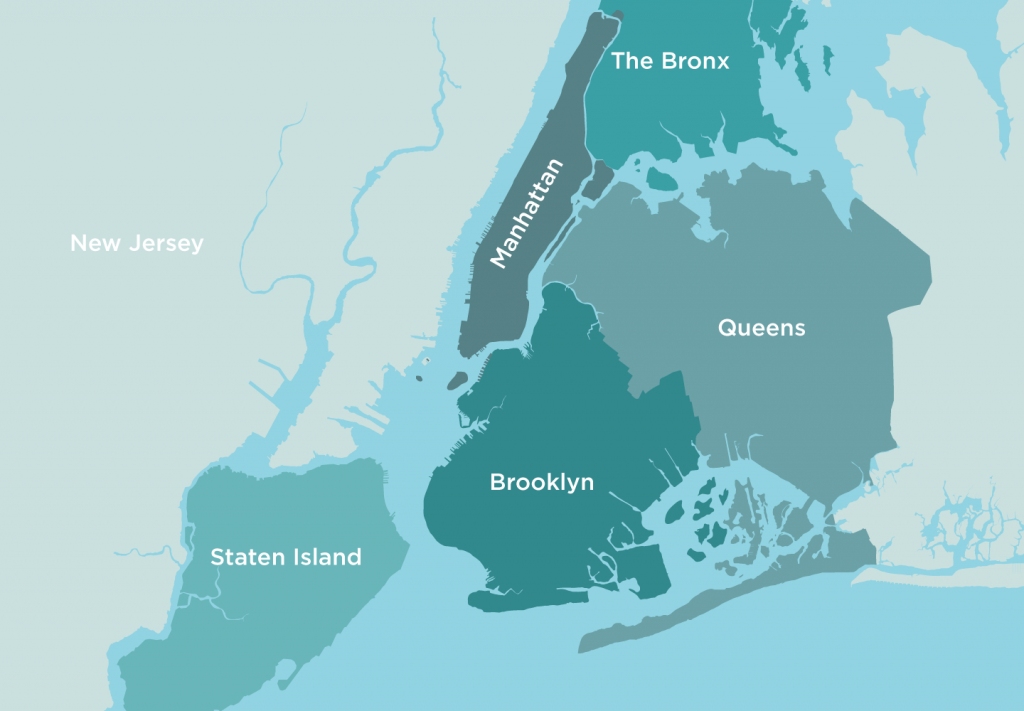

In [18]:
display.Image("ny-boroughs.png", width=500)

As these boroughs define very distinct geographic areas of New York, it makes sense to explore correlations by borough.

## Number of respondents vs. SAT score (by borough)

In [19]:
boro_s = combined.groupby("boro").mean(numeric_only=True)["N_s"]
print(boro_s)

boro
Bronx             435.959229
Brooklyn          575.726415
Manhattan         495.615741
Queens            878.234375
Staten Island    1476.600000
Name: N_s, dtype: float64


In [20]:
boro_t = combined.groupby("boro").mean(numeric_only=True)["N_t"]
print(boro_t)

boro
Bronx            30.559140
Brooklyn         39.179245
Manhattan        31.566667
Queens           57.046875
Staten Island    88.900000
Name: N_t, dtype: float64


In [21]:
boro_p = combined.groupby("boro").mean(numeric_only=True)["N_p"]
print(boro_p)

boro
Bronx            202.333333
Brooklyn         249.754717
Manhattan        203.255556
Queens           318.843750
Staten Island    593.300000
Name: N_p, dtype: float64


Comparing the boroughs, Staten Island has the highest number of survey respondents.

## Safety and Respect score vs. SAT score (by borough)

In [22]:
boro_safety_s = combined.groupby("boro").mean(numeric_only=True)["saf_s_11"]
print(boro_safety_s)

boro
Bronx            6.606577
Brooklyn         6.370755
Manhattan        6.831370
Queens           6.721875
Staten Island    6.530000
Name: saf_s_11, dtype: float64


In [23]:
boro_safety_t = combined.groupby("boro").mean(numeric_only=True)["saf_t_11"]
print(boro_safety_t)

boro
Bronx            7.026882
Brooklyn         6.985849
Manhattan        7.287778
Queens           7.365625
Staten Island    7.210000
Name: saf_t_11, dtype: float64


In [24]:
boro_safety_tot = combined.groupby("boro").mean(numeric_only=True)["saf_tot_11"]
print(boro_safety_tot)

boro
Bronx            7.322581
Brooklyn         7.129245
Manhattan        7.473333
Queens           7.387500
Staten Island    7.200000
Name: saf_tot_11, dtype: float64


Manhattan and Queens have higher safety scores while Staten Island and Brooklyn have the lowest.

## Borough vs. SAT score

In [25]:
boro_score = combined.groupby("boro").mean(numeric_only=True)["sat_score"]
print(boro_score)

boro
Bronx            1157.598203
Brooklyn         1181.364461
Manhattan        1278.331410
Queens           1286.753032
Staten Island    1382.500000
Name: sat_score, dtype: float64


Recall the average SAT score of a student enrolled in a New York school is 1223. The boroughs with higher than average SAT scores are (in order) Staten Island, Queens, and Manhattan. The boroughs lower than the average are Brooklyn and Bronx.

# Part 6: Race correlations with SAT score

The data provides race information as the following:
- `white_per`
- `asian_per`
- `black_per`
- `hispanic_per`

Using this information, we determine whether there are racial differences in SAT scores.

In [26]:
race_fields = ["white_per", "asian_per", "black_per", "hispanic_per"]

<Axes: >

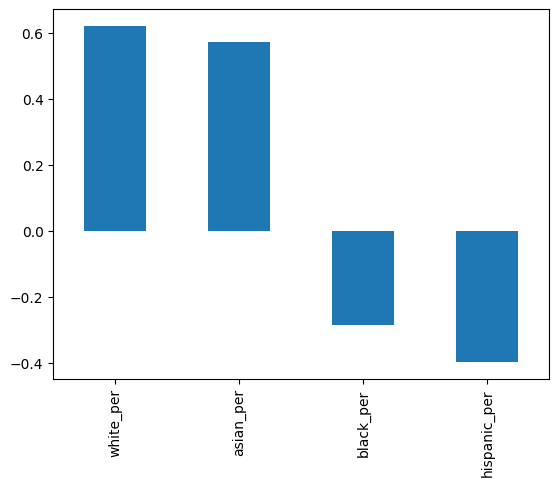

In [27]:
sat_score_corr[race_fields].plot.bar()

The relationship between white and asian students versus SAT score is positively correlated while that of black and hispanic students versus SAT score is negatively correlated. We dig into this deeper.

[Text(0, 800.0, ''),
 Text(0, 1000.0, ''),
 Text(0, 1200.0, ''),
 Text(0, 1400.0, ''),
 Text(0, 1600.0, ''),
 Text(0, 1800.0, ''),
 Text(0, 2000.0, ''),
 Text(0, 2200.0, '')]

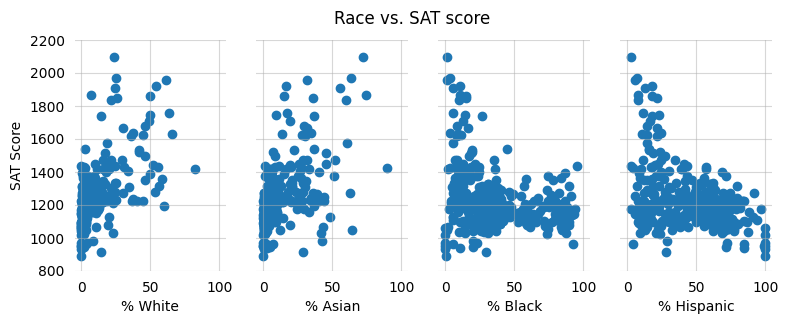

In [28]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(9,3))
fig.suptitle("Race vs. SAT score")
ax1.scatter(x=combined["white_per"], y=combined["sat_score"])
ax2.scatter(x=combined["asian_per"], y=combined["sat_score"])
ax3.scatter(x=combined["black_per"], y=combined["sat_score"])
ax4.scatter(x=combined["hispanic_per"], y=combined["sat_score"])

axes = [ax1, ax2, ax3, ax4]
spines = ["left", "right", "top", "bottom"]

remove_spines()

for ax in axes:
    for spine in spines:
        ax.set_xlim(-5, 105)
        ax.set_ylim(800, 2200)
        
ax1.set_xlabel("% White")
ax2.set_xlabel("% Asian")
ax3.set_xlabel("% Black")
ax4.set_xlabel("% Hispanic")
ax1.set_ylabel("SAT Score")
        
ax2.set_yticklabels([])
ax3.set_yticklabels([])
ax4.set_yticklabels([])

Schools with a lower percentage of black or hispanic population tend to have higher SAT scores, markedly between 0-25%. There are schools with a near 100% hispanic population that have SAT scores 1100 and lower.

We want to see if there is a correlation between % populations and Safety and Respect scores.

[Text(0, 4.0, ''),
 Text(0, 5.0, ''),
 Text(0, 6.0, ''),
 Text(0, 7.0, ''),
 Text(0, 8.0, ''),
 Text(0, 9.0, ''),
 Text(0, 10.0, '')]

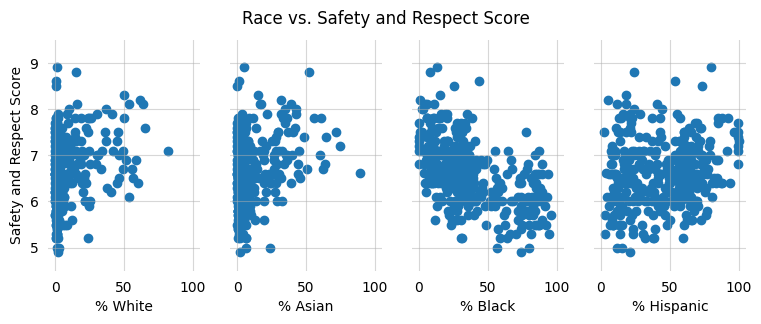

In [29]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(9,3))
fig.suptitle("Race vs. Safety and Respect Score")
ax1.scatter(x=combined["white_per"], y=combined["saf_s_11"])
ax2.scatter(x=combined["asian_per"], y=combined["saf_s_11"])
ax3.scatter(x=combined["black_per"], y=combined["saf_s_11"])
ax4.scatter(x=combined["hispanic_per"], y=combined["saf_s_11"])

axes = [ax1, ax2, ax3, ax4]
spines = ["left", "right", "top", "bottom"]

remove_spines()

for ax in axes:
    for spine in spines:
        ax.set_xlim(-5, 105)
        ax.set_ylim(4.5, 9.5)

ax1.set_xlabel("% White")
ax2.set_xlabel("% Asian")
ax3.set_xlabel("% Black")
ax4.set_xlabel("% Hispanic")
ax1.set_ylabel("Safety and Respect Score")
        
ax2.set_yticklabels([])
ax3.set_yticklabels([])
ax4.set_yticklabels([])

Students, regardless of race, did not rate their school lower than a 4 or higher than a 9. 

There is a positive correlation between schools having high white and asian populations and the schools considered to be safe and respectful.

Schools with a high black population and the schools being rated safe and respectful by the students are negatively correlated. Relating this to the race correlation with SAT score, it is reasonable that schools with high black populations are either located in high-risk areas, have zero to limited equitable opportunities, or do not receive comparable funding to provide a more supportive learning environment.

Schools with a very high (almost 100%) hispanic population are rated above average with Safety and Respect scores of 7-8. These were found however to have below average SAT scores of 1100 or lower. We explore these in more detail.

In [30]:
high_hispanic_pop = combined["hispanic_per"] > 95
print(combined[high_hispanic_pop][["SCHOOL NAME", "boro"]])

                                           SCHOOL NAME       boro
44                       MANHATTAN BRIDGES HIGH SCHOOL  Manhattan
82    WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL  Manhattan
89   GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...  Manhattan
125                ACADEMY FOR LANGUAGE AND TECHNOLOGY      Bronx
141              INTERNATIONAL SCHOOL FOR LIBERAL ARTS      Bronx
176   PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE      Bronx
253                          MULTICULTURAL HIGH SCHOOL   Brooklyn
286             PAN AMERICAN INTERNATIONAL HIGH SCHOOL     Queens


A quick research shows these schools primarily serve recent immigrants to the U.S. It is reasonable that the lower SAT scores are attributed to the students being new to the country and learning the English language.

# Part 7: Gender correlations with SAT score

In [31]:
gender_fields = ["male_per", "female_per"]

<Axes: >

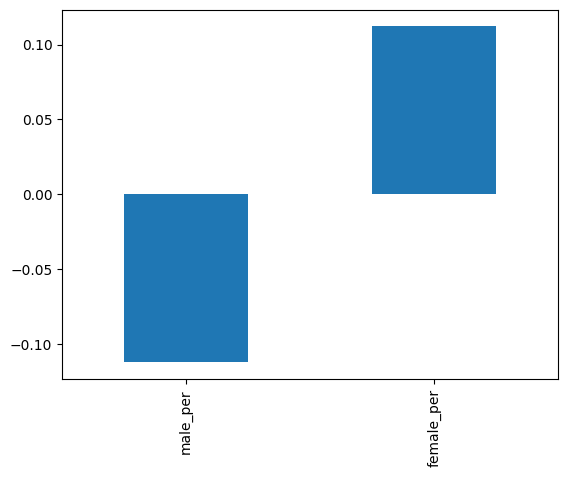

In [32]:
sat_score_corr[gender_fields].plot.bar()

While the relationships to SAT scores are fairly weak, schools with a higher population of males negatively correlates with SAT score while schools with a higher population of females positively correlates with SAT score.

[Text(0, 800.0, ''),
 Text(0, 1000.0, ''),
 Text(0, 1200.0, ''),
 Text(0, 1400.0, ''),
 Text(0, 1600.0, ''),
 Text(0, 1800.0, ''),
 Text(0, 2000.0, ''),
 Text(0, 2200.0, '')]

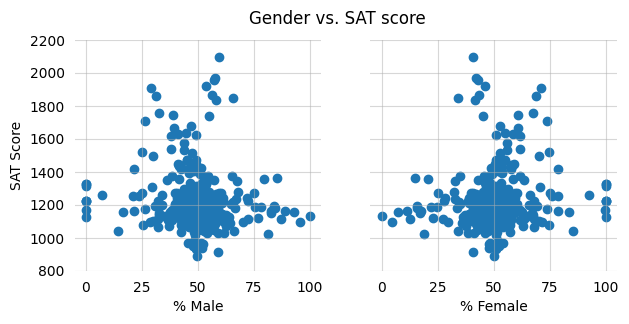

In [33]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(7,3))
fig.suptitle("Gender vs. SAT score")
ax1.scatter(x=combined["male_per"], y=combined["sat_score"])
ax2.scatter(x=combined["female_per"], y=combined["sat_score"])

axes = [ax1, ax2]
spines = ["left", "right", "top", "bottom"]

remove_spines()

for ax in axes:
    for spine in spines:
        ax.set_xlim(-5, 105)
        ax.set_ylim(800, 2200)
        
ax1.set_xlabel("% Male")
ax2.set_xlabel("% Female")
ax1.set_ylabel("SAT Score")
        
ax2.set_yticklabels([])

The relationship to `% male` is very slightly positively skewed while to `% female` is very slightly negatively skewed. This indicates, more specifically with the numbers, that schools with a higher percentage of females have a higher average SAT score.

There are three clusters of note:
- 55-65% male population and 1700-2000 SAT score
- 60-75% female population and 1700-2000 SAT score
- Near 100% female population and 1100-1400 SAT score

## High male population and high SAT score

In [34]:
high_male_perf = (combined["male_per"] > 55) & (combined["sat_score"] > 1700)
print(combined[high_male_perf][["SCHOOL NAME", "boro"]])

                                           SCHOOL NAME           boro
37                              STUYVESANT HIGH SCHOOL      Manhattan
79   HIGH SCHOOL FOR MATHEMATICS, SCIENCE AND ENGIN...      Manhattan
151                       BRONX HIGH SCHOOL OF SCIENCE          Bronx
187                     BROOKLYN TECHNICAL HIGH SCHOOL       Brooklyn
327  QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...         Queens
356                STATEN ISLAND TECHNICAL HIGH SCHOOL  Staten Island


Schools with a high male population and high SAT scores are rigorous with low acceptance rates and specialized towards college prep or STEM (science, technology, engineering, and mathematics).

In [35]:
print(combined[high_male_perf][["saf_s_11", "boro", "white_per", "asian_per", "black_per", "hispanic_per"]])

     saf_s_11           boro  white_per  asian_per  black_per  hispanic_per
37        7.5      Manhattan       23.7       72.1        1.2           2.4
79        7.8      Manhattan       26.1       36.2       15.0          21.2
151       6.8          Bronx       25.4       63.5        3.5           7.2
187       7.0       Brooklyn       21.3       60.3       10.2           7.9
327       7.2         Queens        6.7       74.4       10.5           7.9
356       8.2  Staten Island       61.3       31.8        1.1           5.3


These schools were rated close to 7.0 or higher in Safety and Respect with many of the schools located in Staten Island and Queens.

## High female population and high SAT score

In [36]:
high_female_perf = (combined["female_per"] > 65) & (combined["sat_score"] > 1700)
print(combined[high_female_perf][["SCHOOL NAME", "boro"]])

                                           SCHOOL NAME       boro
5                       BARD HIGH SCHOOL EARLY COLLEGE  Manhattan
26                       ELEANOR ROOSEVELT HIGH SCHOOL  Manhattan
61   FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...  Manhattan
302                        TOWNSEND HARRIS HIGH SCHOOL     Queens


Schools with a high female population and high SAT scores are also rigorous with low acceptance rates. The specializations differ for the schools listed. Bard provides a track to obtain an associate's degree. Laguardia specializes in visual arts and Townsend Harris in Humanities.

In [37]:
print(combined[high_female_perf][["saf_s_11", "boro", "white_per", "asian_per", "black_per", "hispanic_per"]])

     saf_s_11       boro  white_per  asian_per  black_per  hispanic_per
5         8.3  Manhattan       49.8       15.1       15.1          18.2
26        8.1  Manhattan       63.7       17.2        5.5          11.6
61        7.1  Manhattan       49.2       19.6       12.9          16.6
302       7.8     Queens       24.6       55.5        5.9          12.9


These schools were scored highly by students in Safety and Respect with many of the schools located in Manhattan.

## 100% female population and low SAT score

In [38]:
high_female_pop = combined["female_per"] > 95
print(combined[high_female_pop][["SCHOOL NAME", "boro"]])

                                           SCHOOL NAME       boro
15   URBAN ASSEMBLY SCHOOL OF BUSINESS FOR YOUNG WO...  Manhattan
70                     YOUNG WOMEN'S LEADERSHIP SCHOOL  Manhattan
71                     YOUNG WOMEN'S LEADERSHIP SCHOOL  Manhattan
104                      WOMEN'S ACADEMY OF EXCELLENCE      Bronx
191  URBAN ASSEMBLY INSTITUTE OF MATH AND SCIENCE F...   Brooklyn
264     THE URBAN ASSEMBLY SCHOOL FOR CRIMINAL JUSTICE   Brooklyn
329            YOUNG WOMEN'S LEADERSHIP SCHOOL, QUEENS     Queens
338           YOUNG WOMEN'S LEADERSHIP SCHOOL, ASTORIA     Queens


Schools with a high female population were found to be all-girls schools geared towards leadership or specialized preparation. Leadership prep is mainly offered by the Young Women's Leadership Schools based in many locations in New York. Specialized prep such as business, STEM, and criminal justice are offered by the Urban Assembly Institute.

College prep seems secondary which accounts for the lower than average SAT scores.

In [39]:
print(combined[high_female_pop][["saf_s_11", "boro", "white_per", "asian_per", "black_per", "hispanic_per"]])

     saf_s_11       boro  white_per  asian_per  black_per  hispanic_per
15        6.8  Manhattan        1.3        3.4       46.8          48.4
70        7.5  Manhattan        1.6        5.1       31.2          60.1
71        7.5  Manhattan        1.6        5.1       31.2          60.1
104       6.3      Bronx        2.4        2.9       45.9          46.4
191       5.8   Brooklyn        2.6        5.1       79.3          11.7
264       7.7   Brooklyn        9.1       35.0       33.7          21.9
329       6.2     Queens        2.4       21.0       57.3          18.4
338       8.1     Queens       16.2       39.2        4.2          40.4


# Part 8: AP exam scores vs. SAT score

In the U.S., high school students take Advanced Placement (AP) exams to earn college credit. There are AP exams for many different subjects.

It makes sense that the number of students at a school who took AP exams would be highly correlated with the school's SAT scores but we explore the data to assert this.

In [40]:
combined["ap_per"] = combined["AP Test Takers "]/combined["total_enrollment"]

<Axes: xlabel='ap_per', ylabel='sat_score'>

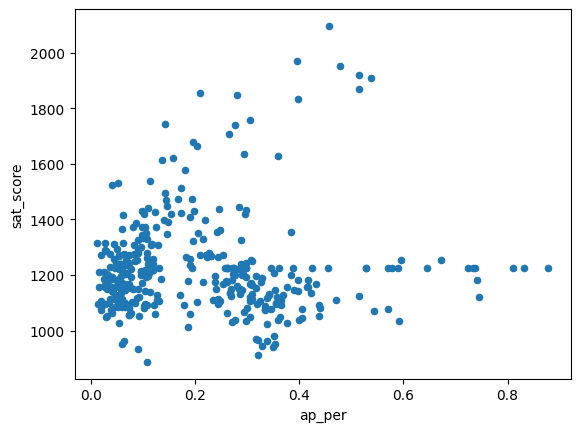

In [41]:
combined.plot.scatter(x="ap_per", y="sat_score")

There is a slight correlation between schools with higher percentage of AP exam takers and SAT score. Schools with up 20% of their students taking AP exams did not score higher than 1600 on the SAT. Schools between 40-60% scored nearly up to 2200. It also appears that for schools with 50% of their students having taken an AP exam have a smaller variance in SAT scores with the mode slightly higher than 1200.